# Monthly Significant Rules by Administration

Data manipulation and plotting converted from `charts/code/monthly_sig_rules_by_admin.Rmd`.

In [74]:
import pandas as pd
from pathlib import Path
import shutil

from utilis.style import GW_COLORS
from utilis.local_utilis import *
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import textwrap
import seaborn as sns
from datetime import datetime



In [66]:
from matplotlib import font_manager as fm
import matplotlib as mpl
from pathlib import Path

FONT_PATH = Path("utilis/style/a-avenir-next-lt-pro.otf")

fm.fontManager.addfont(str(FONT_PATH))
avenir = fm.FontProperties(fname=str(FONT_PATH))
mpl.rcParams["font.family"] = avenir.get_name()
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42


In [54]:
DATA_PATH = Path("data/monthly_significant_rules_by_admin.csv")

df = pd.read_csv(DATA_PATH)
df.columns = df.columns.str.replace(".", " ", regex=False)

df.head()

,Admin,Year,Month,Months in Office,Significant,Economically Significant,Other Significant
0,Reagan,1981,Jan,0,NaN,NaN,NaN
1,Reagan,1981,Feb,1,NaN,0.0,NaN
2,Reagan,1981,Mar,2,NaN,0.0,NaN
3,Reagan,1981,Apr,3,NaN,0.0,NaN
4,Reagan,1981,May,4,NaN,0.0,NaN


In [56]:
df_biden = df[df["Admin"] == "Biden"].copy()
df_biden["Date"] = pd.to_datetime(
    df_biden["Year"].astype(str) + "-" + df_biden["Month"].astype(str) + "-01"
)

df_biden = df_biden.sort_values("Date")

df_biden.head()

,Admin,Year,Month,Months in Office,Significant,Economically Significant,Other Significant,Date
486,Biden,2021,Jan,0,0.0,0.0,0.0,2021-01-01
487,Biden,2021,Feb,1,9.0,6.0,3.0,2021-02-01
488,Biden,2021,Mar,2,11.0,4.0,7.0,2021-03-01
489,Biden,2021,Apr,3,9.0,2.0,7.0,2021-04-01
490,Biden,2021,May,4,16.0,10.0,6.0,2021-05-01


In [57]:
econ_col = "Economically Significant"
other_col = "Other Significant"

df_biden[econ_col] = pd.to_numeric(df_biden[econ_col], errors="coerce").fillna(0)
df_biden[other_col] = pd.to_numeric(df_biden[other_col], errors="coerce").fillna(0)


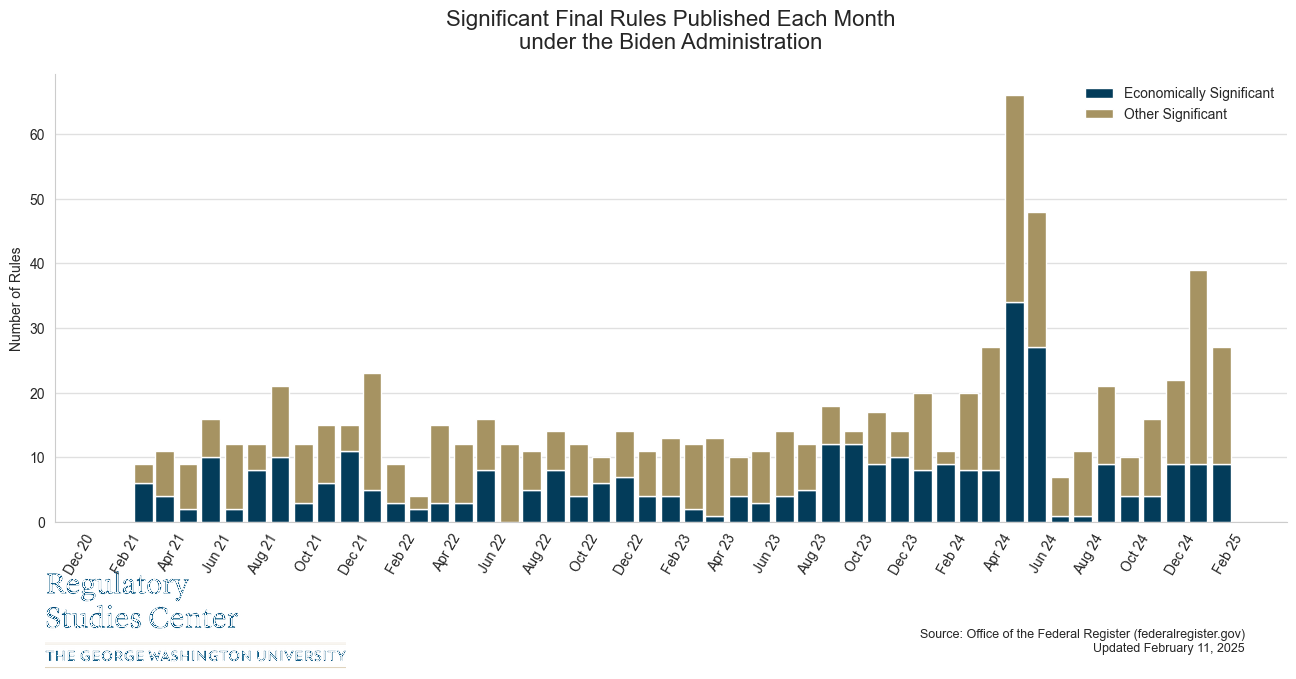

In [87]:


sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(14, 7))
bar_width_days = 25

econ_color = GW_COLORS['GWblue']
other_color = GW_COLORS['GWbuff']
ax.bar(
    df_biden["Date"],
    df_biden[econ_col],
    width=bar_width_days,
    label="Economically Significant",
    color=econ_color,
    align="center",
)

ax.bar(
    df_biden["Date"],
    df_biden[other_col],
    width=bar_width_days,
    bottom=df_biden[econ_col],
    label="Other Significant",
    color=other_color,
    align="center",
)
ax.set_title(
    "Significant Final Rules Published Each Month\nunder the Biden Administration",
    fontsize=16,
    pad=18,
)
ax.set_ylabel("Number of Rules")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))
plt.setp(ax.get_xticklabels(), rotation=60, ha="right")
ax.grid(True, axis="y", linewidth=1, alpha=0.6)
ax.grid(False, axis="x")

sns.despine(ax=ax)
ax.legend(frameon=False)
fig.subplots_adjust(bottom=0.16)



fig.subplots_adjust(bottom=0.22)

ax.set_position([0.08, 0.26, 0.88, 0.64])
logo_path = "utilis/style/gw_ci_rsc_2cs_pos.png"
im = Image.open(logo_path).convert("RGBA")

footer_logo_ax = fig.add_axes([0.03, 0.05, 0.30, 0.14])  # left, bottom, width, height
footer_logo_ax.imshow(np.asarray(im), interpolation="lanczos")
footer_logo_ax.axis("off")
footer_logo_ax.set_aspect("equal", adjustable="box")

fig.text(
    0.93,
    0.07,
    "Source: Office of the Federal Register (federalregister.gov)\nUpdated February 11, 2025",
    ha="right",
    va="bottom",
    fontsize=9,
)

plt.show()
